In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/colab_code/

/content/drive/MyDrive/colab_code


In [3]:
from utils import load_dataset
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.transforms as transforms

from tqdm import tqdm

## Defining the global constants

In [4]:
# Set a fixed seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

In [5]:
TEST_SIZE = 0.2
N_CLASSES = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the data

In [6]:
train_images, train_labels = load_dataset(test=False, color=False)
test_images, test_labels = load_dataset(test=True, color=False)

In [7]:
B, W, H = train_images.shape
train_images = train_images.reshape((B, 1, W, H))
train_images.shape

(800, 1, 224, 224)

In [8]:
B, W, H = test_images.shape
test_images = test_images.reshape((B, 1, W, H))
test_images.shape

(200, 1, 224, 224)

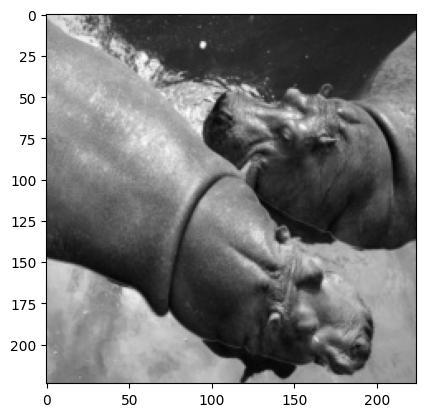

In [9]:
idx = 29
plt.imshow(train_images[idx][0], cmap="gray")

## Convert to torch tensors

In [10]:
X_train = torch.tensor(train_images).type(torch.float32)
y_train = torch.tensor(train_labels).type(torch.long)

X_train.size(), y_train.size()

(torch.Size([800, 1, 224, 224]), torch.Size([800]))

## Normalize the data

In [11]:
mean = X_train.mean()
std = X_train.std()

In [12]:
normalizer = transforms.Normalize(mean, std)

In [13]:
X_train.max(), X_train.mean(), X_train.std()

(tensor(1.), tensor(0.4603), tensor(0.2265))

In [14]:
X_train_norm = normalizer(X_train)

In [15]:
X_train_norm.max(), X_train_norm.mean(), X_train_norm.std()

(tensor(2.3825), tensor(2.9710e-07), tensor(1.))

In [16]:
X_train_norm.shape

torch.Size([800, 1, 224, 224])

## Create datasets and dataloaders for training

In [17]:
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=TEST_SIZE):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [18]:
dataset = TensorDataset(X_train_norm, y_train)

train_dataset, val_dataset = train_val_dataset(dataset, TEST_SIZE)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Define the structure of the ConvNet

In [19]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Dropout(p=0.3),

            nn.Conv2d(16, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Dropout(p=0.3),

            nn.Conv2d(32, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(25088, 10000),
            nn.ReLU(),

            nn.Dropout(p=0.3),

            nn.Linear(10000, 5000),
            nn.ReLU(),

            nn.Dropout(p=0.3),

            nn.Linear(5000, 512),
            nn.ReLU(),

            nn.Dropout(p=0.3),

            nn.Linear(512, N_CLASSES),
        )

    # Method called when we apply the network to an input batch
    def forward(self, X):
        bsize = X.size(0) # batch size
        output = self.features(X) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

## The optimisation loop

In [20]:
def main(train_loader, val_loader, model, lr=1e-3, epochs=5, device=device):

    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr)

    train_loss_per_epoch = []
    train_acc_per_epoch  = []

    val_loss_per_epoch = []
    val_acc_per_epoch  = []

    for e in tqdm(range(epochs)):
        l_train = 0
        acc_train = 0

        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            yhat = model(x)
            l = loss(yhat, y)

            _, YhatInd = torch.max(yhat, 1)

            l_train   += l.item()
            acc_train += torch.where(YhatInd == y, 1, 0).sum().item()

            optim.zero_grad()
            l.backward()
            optim.step()

        train_loss_per_epoch.append(l_train / len(train_loader))
        train_acc_per_epoch.append(acc_train / len(train_loader.dataset))

        model.eval()
        with torch.no_grad():
            n_batches = 0
            l_val     = 0
            acc_val   = 0
            n_samples = 0

            for x, y in val_loader:

                x = x.to(device)
                y = y.to(device)

                n_batches += 1
                n_samples += x.size(0)

                yhat = model(x)
                l = loss(yhat, y)

                _, YhatInd = torch.max(yhat, 1)

                l_val   += l.item()
                acc_val += torch.where(YhatInd == y, 1, 0).sum().item()

            val_loss_per_epoch.append(l_val / len(val_loader))
            val_acc_per_epoch.append(acc_val / len(val_loader.dataset))

        torch.cuda.empty_cache()

    return {
        "train_loss" : train_loss_per_epoch,
        "train_accuracy" : train_acc_per_epoch,
        "val_loss" : val_loss_per_epoch,
        "val_accuracy" : val_acc_per_epoch
    }

## Training a ConvNet

In [21]:
model = ConvNet()

In [22]:
epochs = 50
training_result = main(train_loader, val_loader, model, lr=1e-3, epochs=epochs, device=device)

100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


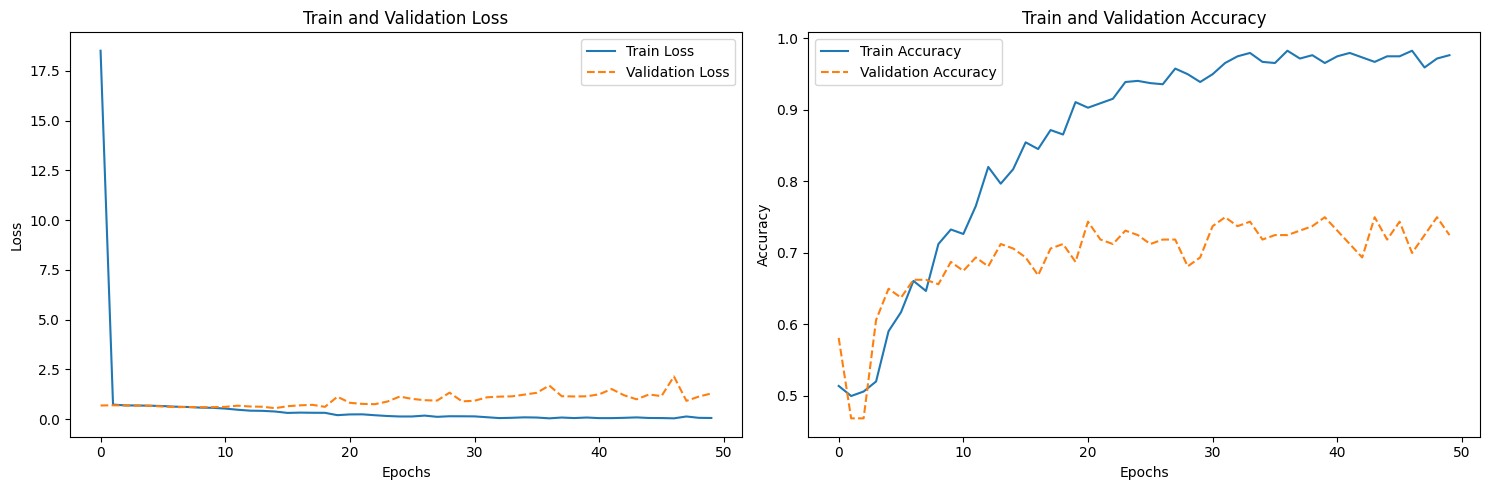

In [23]:
plt.figure(figsize=(15, 5))

range_epochs = range(epochs)

plt.subplot(1, 2, 1)
plt.plot(range_epochs, training_result["train_loss"], label='Train Loss')
plt.plot(range_epochs, training_result["val_loss"], label='Validation Loss', linestyle='--')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range_epochs, training_result["train_accuracy"], label='Train Accuracy')
plt.plot(range_epochs, training_result["val_accuracy"], label='Validation Accuracy', linestyle='--')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

In [24]:
def compute_accuracy(model, test_loader):
    correct = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Précision sur les données de test: {accuracy:.2f}%')

In [30]:
X_test = torch.tensor(test_images).type(torch.float32).cuda()
y_test = torch.tensor(test_labels).type(torch.long).cuda()

X_test_norm = normalizer(X_test)

test_dataset = TensorDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [31]:
compute_accuracy(model, test_loader)

Précision sur les données de test: 70.00%


# Save the model

In [32]:
torch.save(model.state_dict(), "model_cnn_wc.pch")